<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/path_planning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

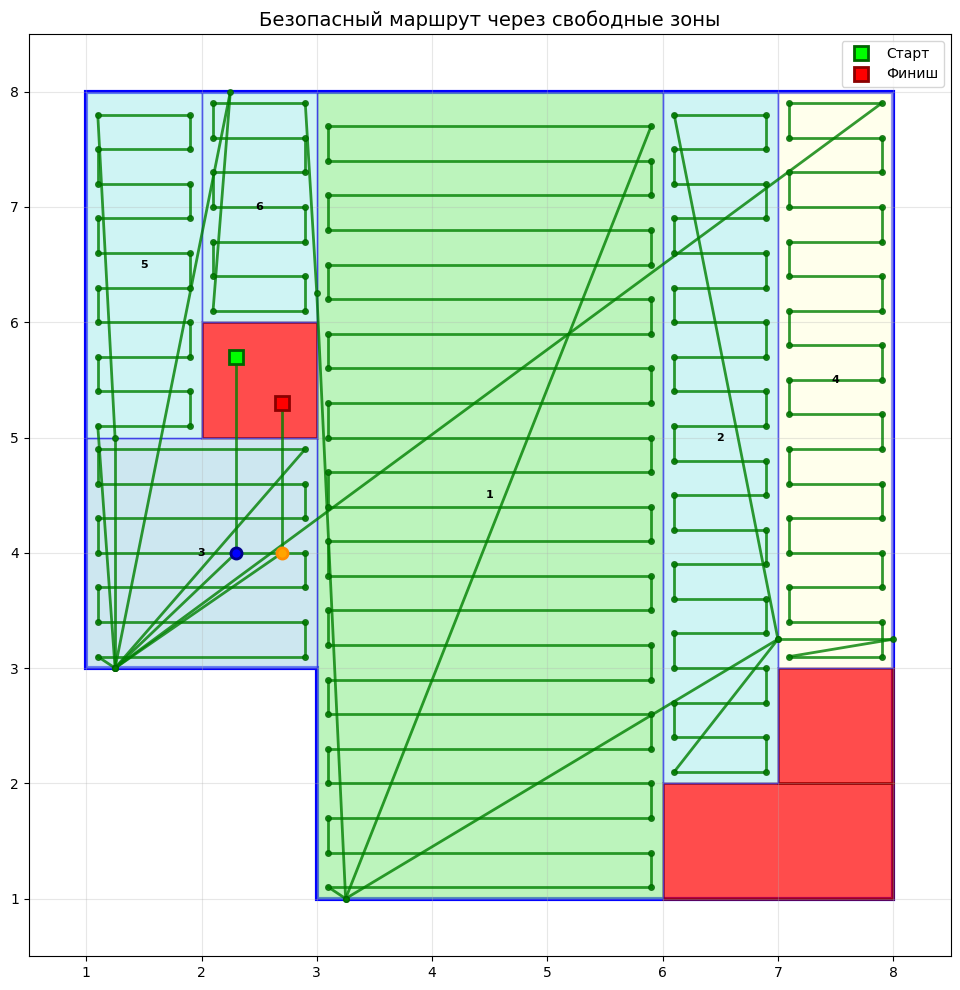

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from typing import List, Tuple, Optional, Dict
import random
from dataclasses import dataclass

@dataclass
class Point:
    x: float
    y: float

    def to_array(self) -> np.ndarray:
        return np.array([self.x, self.y])

    @staticmethod
    def from_array(arr: np.ndarray) -> 'Point':
        return Point(arr[0], arr[1])

class GeometryUtils:
    """Утилиты для геометрических вычислений"""

    @staticmethod
    def point_in_polygon(point: Point, polygon: List[Point]) -> bool:
        """Проверяет, находится ли точка внутри полигона"""
        x, y = point.x, point.y
        n = len(polygon)
        inside = False

        p1 = polygon[0]
        for i in range(1, n + 1):
            p2 = polygon[i % n]
            if y > min(p1.y, p2.y):
                if y <= max(p1.y, p2.y):
                    if x <= max(p1.x, p2.x):
                        if p1.y != p2.y:
                            xinters = (y - p1.y) * (p2.x - p1.x) / (p2.y - p1.y) + p1.x
                        if p1.x == p2.x or x <= xinters:
                            inside = not inside
            p1 = p2

        return inside

    @staticmethod
    def lines_intersect(a1: Point, a2: Point, b1: Point, b2: Point) -> bool:
        """Проверяет пересечение двух отрезков"""
        def ccw(A: Point, B: Point, C: Point) -> bool:
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)

        return (ccw(a1, b1, b2) != ccw(a2, b1, b2) and
                ccw(a1, a2, b1) != ccw(a1, a2, b2))

    @staticmethod
    def distance(p1: Point, p2: Point) -> float:
        """Вычисляет расстояние между двумя точками"""
        return np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

class BoundingBox:
    """Ограничивающая рамка"""

    def __init__(self, x1: float, y1: float, x2: float, y2: float):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.width = x2 - x1
        self.height = y2 - y1
        self.center = Point((x1 + x2) / 2, (y1 + y2) / 2)

    def contains_point(self, point: Point) -> bool:
        """Проверяет, содержит ли рамка точку"""
        return (self.x1 <= point.x <= self.x2 and
                self.y1 <= point.y <= self.y2)

    def intersects(self, other: 'BoundingBox') -> bool:
        """Проверяет пересечение с другой рамкой"""
        return not (self.x2 < other.x1 or self.x1 > other.x2 or
                   self.y2 < other.y1 or self.y1 > other.y2)

class FreeZone:
    """Свободная зона для движения"""

    def __init__(self, vertices: List[Point]):
        self.vertices = vertices
        self.bbox = self._calculate_bbox()
        self.center = self.bbox.center
        self.neighbors: List['FreeZone'] = []

    def _calculate_bbox(self) -> BoundingBox:
        """Вычисляет ограничивающую рамку"""
        x_coords = [v.x for v in self.vertices]
        y_coords = [v.y for v in self.vertices]
        return BoundingBox(min(x_coords), min(y_coords),
                          max(x_coords), max(y_coords))

    def get_boundary_points(self, step: float = 0.5) -> List[Point]:
        """Генерирует точки на границе зоны"""
        points = []
        bbox = self.bbox

        # Нижняя граница
        x_bottom = np.arange(bbox.x1 + step/2, bbox.x2, step)
        points.extend([Point(x, bbox.y1) for x in x_bottom])

        # Правая граница
        y_right = np.arange(bbox.y1 + step/2, bbox.y2, step)
        points.extend([Point(bbox.x2, y) for y in y_right])

        # Верхняя граница
        x_top = np.arange(bbox.x2 - step/2, bbox.x1, -step)
        points.extend([Point(x, bbox.y2) for x in x_top])

        # Левая граница
        y_left = np.arange(bbox.y2 - step/2, bbox.y1, -step)
        points.extend([Point(bbox.x1, y) for y in y_left])

        return points

    def add_neighbor(self, neighbor: 'FreeZone'):
        """Добавляет соседнюю зону"""
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)

class Obstacle:
    """Препятствие"""

    def __init__(self, vertices: List[Point]):
        self.vertices = vertices
        self.bbox = self._calculate_bbox()

    def _calculate_bbox(self) -> BoundingBox:
        """Вычисляет ограничивающую рамку"""
        x_coords = [v.x for v in self.vertices]
        y_coords = [v.y for v in self.vertices]
        return BoundingBox(min(x_coords), min(y_coords),
                          max(x_coords), max(y_coords))

class CollisionDetector:
    """Детектор столкновений"""

    def __init__(self, obstacles: List[Obstacle], boundary: List[Point]):
        self.obstacles = obstacles
        self.boundary = boundary

    def line_intersects_obstacle(self, p1: Point, p2: Point) -> bool:
        """Проверяет пересечение отрезка с любым препятствием"""
        for obstacle in self.obstacles:
            if self._line_intersects_obstacle(p1, p2, obstacle):
                return True
        return False

    def _line_intersects_obstacle(self, p1: Point, p2: Point, obstacle: Obstacle) -> bool:
        """Проверяет пересечение отрезка с конкретным препятствием"""
        # Проверяем, лежат ли точки внутри препятствия
        if (obstacle.bbox.contains_point(p1) or
            obstacle.bbox.contains_point(p2)):
            return True

        # Проверяем пересечение с каждой стороной препятствия
        vertices = obstacle.vertices
        n = len(vertices)

        for i in range(n):
            side_p1 = vertices[i]
            side_p2 = vertices[(i + 1) % n]

            if GeometryUtils.lines_intersect(p1, p2, side_p1, side_p2):
                return True

        return False

    def can_connect_directly(self, p1: Point, p2: Point) -> bool:
        """Проверяет, можно ли соединить точки напрямую"""
        return not self.line_intersects_obstacle(p1, p2)

class SnakePlanner:
    """Планировщик траектории змейки"""

    def __init__(self, border_offset: float = 0.1, step_y: float = 0.3):
        self.border_offset = border_offset
        self.step_y = step_y

    def generate_snake_trajectory(self, zone: FreeZone) -> List[Point]:
        """Генерирует траекторию змейкой внутри зоны"""
        bbox = zone.bbox
        x_min, x_max = bbox.x1, bbox.x2
        y_min, y_max = bbox.y1, bbox.y2

        x_coords = [x_min + self.border_offset, x_max - self.border_offset]
        y_coords = np.arange(y_min + self.border_offset,
                           y_max - self.border_offset, self.step_y)

        if len(y_coords) == 0:
            return [zone.center]

        points = []
        for i, y in enumerate(y_coords):
            if i % 2 == 0:  # Четные строки - слева направо
                for x in x_coords:
                    points.append(Point(x, y))
            else:  # Нечетные строки - справа налево
                for x in reversed(x_coords):
                    points.append(Point(x, y))

        return points

class ZoneConnector:
    """Соединитель зон"""

    def __init__(self, collision_detector: CollisionDetector):
        self.collision_detector = collision_detector

    def find_connection_points(self, zone1: FreeZone, zone2: FreeZone) -> Optional[Tuple[Point, Point]]:
        """Находит точки соединения между двумя зонами"""
        boundary1 = zone1.get_boundary_points()
        boundary2 = zone2.get_boundary_points()

        for point1 in boundary1:
            for point2 in boundary2:
                if self.collision_detector.can_connect_directly(point1, point2):
                    return point1, point2
        return None

    def find_connection_to_zone(self, point: Point, zone: FreeZone) -> Optional[Point]:
        """Находит точку соединения от точки к зоне"""
        boundary_points = zone.get_boundary_points()

        for boundary_point in boundary_points:
            if self.collision_detector.can_connect_directly(point, boundary_point):
                return boundary_point
        return None

class SpacePartitioner:
    """Разбиватель пространства на свободные зоны"""

    def __init__(self, boundary: List[Point]):
        self.boundary = boundary
        self.bbox = self._calculate_bbox()

    def _calculate_bbox(self) -> BoundingBox:
        """Вычисляет ограничивающую рамку границы"""
        x_coords = [v.x for v in self.boundary]
        y_coords = [v.y for v in self.boundary]
        return BoundingBox(min(x_coords), min(y_coords),
                          max(x_coords), max(y_coords))

    def partition_space(self, obstacles: List[Obstacle]) -> List[FreeZone]:
        """Разбивает пространство на свободные зоны"""
        grid_step = 0.5
        x_coords = np.arange(self.bbox.x1, self.bbox.x2 + grid_step, grid_step)
        y_coords = np.arange(self.bbox.y1, self.bbox.y2 + grid_step, grid_step)

        # Создаем сетку ячеек
        grid = np.zeros((len(y_coords)-1, len(x_coords)-1), dtype=bool)
        visited = np.zeros_like(grid)

        # Помечаем занятые ячейки
        for i in range(len(x_coords)-1):
            for j in range(len(y_coords)-1):
                cell_center = Point((x_coords[i] + x_coords[i+1])/2,
                                  (y_coords[j] + y_coords[j+1])/2)

                if not GeometryUtils.point_in_polygon(cell_center, self.boundary):
                    grid[j, i] = True
                    continue

                # Проверяем пересечение с препятствиями
                for obstacle in obstacles:
                    if obstacle.bbox.contains_point(cell_center):
                        grid[j, i] = True
                        break

        # Объединяем ячейки в зоны
        zones = []
        for j in range(len(y_coords)-1):
            i = 0
            while i < len(x_coords)-1:
                if visited[j, i] or grid[j, i]:
                    i += 1
                    continue

                width = 1
                while (i + width < len(x_coords)-1 and
                       not visited[j, i + width] and
                       not grid[j, i + width]):
                    width += 1

                height = 1
                can_extend_height = True
                while can_extend_height and j + height < len(y_coords)-1:
                    for w in range(width):
                        if visited[j + height, i + w] or grid[j + height, i + w]:
                            can_extend_height = False
                            break
                    if can_extend_height:
                        height += 1

                # Создаем зону
                vertices = [
                    Point(x_coords[i], y_coords[j]),
                    Point(x_coords[i + width], y_coords[j]),
                    Point(x_coords[i + width], y_coords[j + height]),
                    Point(x_coords[i], y_coords[j + height])
                ]
                zones.append(FreeZone(vertices))

                # Помечаем ячейки как посещенные
                for h in range(height):
                    for w in range(width):
                        if j + h < len(y_coords)-1 and i + w < len(x_coords)-1:
                            visited[j + h, i + w] = True

                i += width

        return zones

class PathPlanner:
    """Планировщик полного пути"""

    def __init__(self, zones: List[FreeZone], obstacles: List[Obstacle],
                 boundary: List[Point], start: Point, end: Point,
                 start_waypoints: List[Point] = None,
                 end_waypoints: List[Point] = None):
        self.zones = zones
        self.start = start
        self.end = end
        self.start_waypoints = start_waypoints or []
        self.end_waypoints = end_waypoints or []

        self.collision_detector = CollisionDetector(obstacles, boundary)
        self.zone_connector = ZoneConnector(self.collision_detector)
        self.snake_planner = SnakePlanner()

    def _find_closest_zone(self, point: Point) -> Optional[FreeZone]:
        """Находит ближайшую зону к точке"""
        if not self.zones:
            return None

        closest_zone = None
        min_distance = float('inf')

        for zone in self.zones:
            distance = GeometryUtils.distance(point, zone.center)
            if distance < min_distance:
                min_distance = distance
                closest_zone = zone

        return closest_zone

    def build_complete_path(self) -> List[Point]:
        """Строит полный путь через все зоны"""
        if not self.zones:
            return []

        # Сортируем зоны для последовательного обхода
        sorted_zones = sorted(self.zones, key=lambda z: (z.center.x, z.center.y))
        path = [self.start]

        # Добавляем стартовые точки
        for waypoint in self.start_waypoints:
            path.append(waypoint)

        # Подключаемся к первой зоне
        last_point = path[-1]
        start_zone = self._find_closest_zone(last_point)
        if start_zone:
            connection = self.zone_connector.find_connection_to_zone(last_point, start_zone)
            if connection:
                path.append(connection)

        # Обрабатываем все зоны
        for i, zone in enumerate(sorted_zones):
            snake_path = self.snake_planner.generate_snake_trajectory(zone)

            if i == 0:
                path.extend(snake_path)
            else:
                prev_zone = sorted_zones[i-1]
                connection = self.zone_connector.find_connection_points(prev_zone, zone)
                if connection:
                    point1, point2 = connection
                    path.extend([point1, point2])
                path.extend(snake_path)

        # Подключаемся к конечным точкам
        if self.end_waypoints:
            end_zone = self._find_closest_zone(self.end_waypoints[0])
        else:
            end_zone = self._find_closest_zone(self.end)

        if end_zone and path:
            last_path_point = path[-1]
            end_connection = self.zone_connector.find_connection_to_zone(last_path_point, end_zone)
            if end_connection:
                path.append(end_connection)

        # Добавляем конечные точки
        for waypoint in self.end_waypoints:
            path.append(waypoint)

        path.append(self.end)
        return path

class Visualizer:
    """Визуализатор"""

    def __init__(self, boundary: List[Point]):
        self.boundary = boundary
        self.bbox = BoundingBox(
            min(v.x for v in boundary), min(v.y for v in boundary),
            max(v.x for v in boundary), max(v.y for v in boundary)
        )
        self.fig, self.ax = plt.subplots(figsize=(12, 10))

    def _get_random_light_color(self):
        """Генерирует случайный светлый цвет"""
        colors = ['lightpink', 'lightblue', 'lightyellow', 'lightgreen', 'lightcyan',
                  'lavender', 'peachpuff', 'paleturquoise', 'lemonchiffon', 'mistyrose']
        return random.choice(colors)

    def plot_scene(self, zones: List[FreeZone], obstacles: List[Obstacle],
                   path: List[Point], start: Point, end: Point,
                   start_waypoints: List[Point], end_waypoints: List[Point]):
        """Визуализирует всю сцену"""
        self.ax.clear()

        # Рисуем границу
        boundary_vertices = [[v.x, v.y] for v in self.boundary]
        boundary_patch = Polygon(boundary_vertices, fill=False, edgecolor='blue', linewidth=3)
        self.ax.add_patch(boundary_patch)

        # Рисуем препятствия
        for obstacle in obstacles:
            obstacle_vertices = [[v.x, v.y] for v in obstacle.vertices]
            obstacle_patch = Polygon(obstacle_vertices, fill=True, facecolor='red',
                                   alpha=0.7, edgecolor='darkred', linewidth=2)
            self.ax.add_patch(obstacle_patch)

        # Рисуем свободные зоны
        for i, zone in enumerate(zones):
            zone_vertices = [[v.x, v.y] for v in zone.vertices]

            # Заливка
            fill_patch = Polygon(zone_vertices, fill=True,
                               facecolor=self._get_random_light_color(), alpha=0.6)
            self.ax.add_patch(fill_patch)

            # Контур
            border_patch = Polygon(zone_vertices, fill=False,
                                 edgecolor='blue', linewidth=1, alpha=0.7)
            self.ax.add_patch(border_patch)

            # Номер зоны
            self.ax.text(zone.center.x, zone.center.y, str(i+1),
                        ha='center', va='center', fontsize=8, fontweight='bold')

        # Рисуем путь
        if len(path) > 1:
            path_x = [p.x for p in path]
            path_y = [p.y for p in path]

            # Линии
            for i in range(len(path) - 1):
                self.ax.plot([path_x[i], path_x[i+1]], [path_y[i], path_y[i+1]],
                           color='green', linewidth=2, alpha=0.8)

            # Точки
            self.ax.plot(path_x, path_y, 'o', markersize=4, markerfacecolor='green',
                       markeredgecolor='darkgreen', markeredgewidth=1, alpha=0.8)

        # Рисуем специальные точки
        self._plot_special_points(start, end, start_waypoints, end_waypoints)

        # Настройки отображения
        margin = 0.5
        self.ax.set_xlim(self.bbox.x1 - margin, self.bbox.x2 + margin)
        self.ax.set_ylim(self.bbox.y1 - margin, self.bbox.y2 + margin)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title('Безопасный маршрут через свободные зоны', fontsize=14)

        # Легенда
        self.ax.legend(loc='upper right')

    def _plot_special_points(self, start: Point, end: Point,
                           start_waypoints: List[Point], end_waypoints: List[Point]):
        """Рисует специальные точки (старт, финиш, промежуточные)"""
        # Старт и финиш
        self.ax.plot(start.x, start.y, 's', markersize=10, markerfacecolor='lime',
                   markeredgecolor='darkgreen', markeredgewidth=2, label='Старт')
        self.ax.plot(end.x, end.y, 's', markersize=10, markerfacecolor='red',
                   markeredgecolor='darkred', markeredgewidth=2, label='Финиш')

        # Стартовые точки
        for i, wp in enumerate(start_waypoints):
            self.ax.plot(wp.x, wp.y, 'o', markersize=8, markerfacecolor='blue',
                       markeredgecolor='darkblue', markeredgewidth=2)

        # Конечные точки
        for i, wp in enumerate(end_waypoints):
            self.ax.plot(wp.x, wp.y, 'o', markersize=8, markerfacecolor='orange',
                       markeredgecolor='darkorange', markeredgewidth=2)

    def show(self):
        """Показывает график"""
        plt.tight_layout()
        plt.show()

def main():
    """Основная функция"""
    # Граница рабочей области
    boundary = [
        Point(1, 3), Point(1, 8), Point(8, 8),
        Point(8, 1), Point(3, 1), Point(3, 3)
    ]

    # Препятствия
    obstacles_data = [
        [Point(6, 1), Point(8, 1), Point(8, 2), Point(6, 2)],
        [Point(7, 2), Point(8, 2), Point(8, 3), Point(7, 3)],
        [Point(2, 5), Point(3, 5), Point(3, 6), Point(2, 6)],
    ]

    obstacles = [Obstacle(obs) for obs in obstacles_data]

    # Точки маршрута
    start_point = Point(2.3, 5.7)
    end_point = Point(2.7, 5.3)
    start_waypoints = [Point(2.3, 4.0)]
    end_waypoints = [Point(2.7, 4.0)]

    # Разбиваем пространство на зоны
    partitioner = SpacePartitioner(boundary)
    zones = partitioner.partition_space(obstacles)

    # Планируем путь
    path_planner = PathPlanner(zones, obstacles, boundary, start_point, end_point,
                              start_waypoints, end_waypoints)
    path = path_planner.build_complete_path()

    # Визуализируем
    visualizer = Visualizer(boundary)
    visualizer.plot_scene(zones, obstacles, path, start_point, end_point,
                         start_waypoints, end_waypoints)
    visualizer.show()

if __name__ == "__main__":
    main()